# **Travelling Salesman Problem**

# Introduction
**The Travelling Salesman Problem:**

Given a complete weighted graph, the problem is to find the shortest possible hamiltonian tour.   

**The Metric Traveling Salesman Problem:**

The special case of the TSP where the input instances satisfy the triangle
inequality.        
$\forall i, j, k \in V$,

$d(i, k) \leq d(i, j) + d(j, k)$

**Assumptions:** 
- The graph is complete.

---
**Implementation:**   
We use two metrics for the 
 of algorithms:
1. Performance Ratio: ratios of lengths of vertex covers (wrt Brute force or ILP).
2. Execution time of various algorithms.

#Import

In [1]:
%%capture
import random
from math import sqrt,ceil
from itertools import permutations, product  
import matplotlib.pyplot as plt
from sys import stdout as out
import numpy as np
import networkx as nx
import copy
import pandas as pd
import time
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','svg')

In [2]:
%%capture
!pip install mip
from mip import Model, xsum, minimize, BINARY

# Graph Generation

This function generates a symmetric Adjacency Matrix representation of a randomly generated complete weighted graph.

The generated weights should follow triangle inequality (metric TSP).   

**Implementation:**
- We generate weights randomly in the range ($\lceil$*MAX_WEIGHT*/2$\rceil$, *MAX_WEIGHT*-1) which ensures that any 3 numbers generated will follow triangle inequality. 


In [3]:
def generate_graph(n, MAX_WEIGHT = 100):
    
    # Adj Matrix of 0's
    graph = [[0]*n for i in range(n)]  
    b = MAX_WEIGHT - 1
    a = MAX_WEIGHT // 2
    for i in range(n):
        for j in range(i+1,n):
            weight = (random.randint(a,b))
            graph[i][j] = weight
            graph[j][i] = weight

    return graph

# Exact Algorithms

## Brute Force

Iterate through all possible hamiltonian tours possible for the graph (Here, a circular permutation of list of vertices represents a possible tour) and take the tour with minimum path length.   


---


### **Algorithm Brute Force:**   
**Input:** Adjacency matrix representation of a graph $G$.  
**Output:** A Hamiltonian tour in $G$ (A List of vertices) and the cost of this tour.
1. Get all circular permutations of vertex list. Each permutation represents a hamiltonian tour.
2. For every tour, calculate the path length and get the minimum.


---

**Implementation :**
 
- Rather than checking all permutations of vertex list, we fix the first vertex to 0 and get permutations for the rest of the list to avoid multiple representations for a tour. (For example 0 $\rightarrow$ 1 $\rightarrow$ 2 $\rightarrow$ 0 and 1 $\rightarrow$ 2 $\rightarrow$ 0 $\rightarrow$ 1 are the same tour, if we fix 0 as first vertex, we avoid this repetition). 
- Doing this still leaves two representations for every tour, clockwise and anticlockwise, increasing execution time by a factor of 2.

In [4]:
def brute_force(graph): 
    min_length = 100000000
    min_hamiltonian_path = []

    n = len(graph)

    # Generate all permutations from 1 to n-1
    l = list(permutations(range(1, n)))         
    
    # Calculate Path Length of the particular permutation 
    for perm in l:
        path_length = graph[0][perm[0]]         
        for i in range(len(perm)-1):
            path_length += graph[perm[i]][perm[(i+1)]]
        path_length += graph[perm[len(perm)-1]][0]

        if (path_length < min_length):
            min_length = path_length
            min_hamiltonian_path = list(perm)
    
    # Go back to the start point        
    min_hamiltonian_path.append(0)
    return [0] + (min_hamiltonian_path), min_length

## Integer Linear Programming   
**Input:** Adjacency matrix representation of a graph $G$.  
**Output:** A Hamiltonian tour in $G$ (A List of vertices) and the cost of this tour.    


$\begin{align}
\text{min} \quad & \sum_{i = 1}^{n} \sum_{j = 1, j \neq i}^{n} c_{ij} x_{ij}, \\
\text{subject to} \\
& \sum_{i=1, i \neq j}^{n} x_{ij} = 1, \quad j=1,2,…,n,\\
& \sum_{j=1, j \neq i}^{n} x_{ij} = 1, \quad i=1,2,…,n,\\
& u_i - u_j + n x_{ij} \leq n-1, \quad 2 \leq i \neq j \leq n, \\
& x_{ij} \in \{0,1\} \quad i, j =1,2,…,n, \quad i \neq j, \\
& u_i \in \mathbb{R}^+ \quad i=1,2,…,n. \\
\end{align}$

---
**Notation**

$x_{ij} = \begin{cases}
& 1 \quad \text{ if the route includes a direct link between vertices } i \text{ and } j,  \\
& 0 \quad \text{ otherwise}.
\end{cases}$

In addition, for each vertex, **$i$ = 1,2, ... , n**,   
$u_{i}$ is an auxiliary variable indicating the sequential order of each point in the produced route.    
$c_{ij}$ is the distance between the vertices $i$ and $j$.   

---

- The first set of equalities requires that each vertex is arrived at from exactly one other vertex.    
- The second set of equalities requires that from each vertex there is a departure to exactly one next vertex.   
- The third set of inequalities prevents the formation of sub-tours and thus guarantees the formation of a single tour, covering all the vertices.

In [5]:
def ilp(graph):
    c = graph
    n = len(graph)
    V = set([x for x in range(n)])

    model = Model()

    # binary variables indicating if arc (i,j) is used on the route or not
    x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

    # continuous variable to prevent subtours: each vertex will have a different sequential id in the planned route except the first one
    y = [model.add_var() for i in V]

    # objective function: minimize the distance
    model.objective = minimize(xsum(c[i][j]*x[i][j] for i in V for j in V))

    # constraint : leave each vertex only once
    for i in V:
        model += xsum(x[i][j] for j in V - {i}) == 1

    # constraint : enter each vertex only once
    for i in V:
        model += xsum(x[j][i] for j in V - {i}) == 1

    # subtour elimination
    for (i, j) in product(V - {0}, V - {0}):
        if i != j:
            model += y[i] - (n+1)*x[i][j] >= y[j]-n

    # optimizing
    model.optimize()
    V = list(V)
    
    # checking if a solution was found
    if model.num_solutions:
        distance = model.objective_value
        hamiltonian_cycle = [V[0]]
        nc = 0
        while True:
            nc = [i for i in V if x[nc][i].x >= 0.99][0]
            hamiltonian_cycle.append(V[nc])
            if nc == 0:
                break
        return hamiltonian_cycle,int(distance)

# Approximation Algorithms

## MST Approximation
### **Algorithm MST:**   
**Input:** Adjacency matrix representation of a graph $G$.  
**Output:** A Hamiltonian tour in $G$ (A List of vertices) and the cost of this tour.

1. Find a minimum spanning tree $T$ in $G$.
2. Construct a multigraph $T^{'}$ by making two copies of each edge in $T$.
3. Find an Eulerian tour $ET$ in $T^{'}$.
4. Construct a Hamiltonian tour by short-circuiting the Eulerian tour. That is, starting at any vertex, follow the Eulerian tour as long as new vertices are being visited. At any point where the Eulerian tour repeats a vertex, jump directly to the next unvisited vertex. Finally, complete the cycle by returning to the starting vertex.
---
### **Perfomance Ratio: 2**   
- Given any collection of edges $H$ from $G$, $cost(H)$ denotes the sum of all the edge lengths/weights for the edges in $H$.   
- $T$ is the MST, $T^{'}$ is the multigraph made from doubling all the edges, $ET$ is the Eulerian Tour.   
- $cost(T) \leq cost(OPT(G))$ because any Hamiltonian cycle with an edge removes gives a spanning tree.   
- Thus, $cost(ET) = cost(T^{'}) \leq 2*cost(OPT(G))$  because $cost(T^{'}) = 2*cost(T)$ and $cost(T) \leq cost(OPT(G))$.   
- Finally short-cut procedure ensures that $cost(approx_{mst}(G)) \leq cost(ET)$.   
- Therefore $cost(approx_{mst}(G)) \leq 2*cost(OPT(G))$.
- This gives an upper bound of **2**.
---
**Implementation :**
- We convert the adjacency matrix representation of a graph into a networkx graph object in order to use multiple useful functions from the networkx library.

In [6]:
def mst_algo(graph):

    # Make an Networkx Graph
    nx_graph = nx.to_networkx_graph(np.array(graph))
    
    # Find Minimum Spanning Tree of the graph
    mst = nx.minimum_spanning_tree(nx_graph)

    # Construct a multigraph by making 2 copies of each edge
    G = nx.MultiGraph()
    edge_list = nx.to_edgelist(mst)
    for edge in edge_list:
        G.add_edge(edge[0],edge[1],weight=edge[2]['weight'])
        G.add_edge(edge[0],edge[1],weight=edge[2]['weight'])
    multigraph_mst = G

    # Find an euler tour
    euler_tour = list(nx.eulerian_circuit(multigraph_mst))
    
    # Construct a hamiltonian tour
    hamiltonian_cycle = []

    for edge in euler_tour:
        if edge[0] not in hamiltonian_cycle:
            hamiltonian_cycle.append(edge[0])

    hamiltonian_cycle.append(euler_tour[0][0])

    # Find cost of the tour
    distance = 0
    for i in range(len(hamiltonian_cycle)-1):
        distance += graph[hamiltonian_cycle[i]][hamiltonian_cycle[i+1]]
    return hamiltonian_cycle, distance

## Christofides Approximation
We convert the adjacency matrix representation of a graph into a networkx graph object in order to use multiple useful functions from the networkx library.

---
### **Algorithm Christofides:**   
**Input:** Adjacency matrix representation of a graph $G$.  
**Output:** A Hamiltonian tour in $G$ (A List of vertices) and the cost of this tour.  
1. Create a minimum spanning tree $T$ of $G$.
2. Let $O$ be the set of vertices with odd degree in $T$. By the handshaking lemma, $O$ has an even number of vertices.
3. Find a minimum-weight perfect matching $M$ in the induced subgraph given by the vertices from $O$.
4. Combine the edges of $M$ and $T$ to form a connected multigraph $H$ in which each vertex has even degree.
5. Form an Eulerian circuit in $H$.
6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).
---
### **Performance Ratio: 1.5**
- Given any collection of edges $H$ from $G$, $cost(H)$ denotes the sum of all the edge lengths/weights for the edges in H.   
- Let $OPT(G)$ be the optimal TSP tour and Let $T$ be the Minimum spanning tree.   
- Let $M$ be the the minimum weight matching on the set $O$ of odd degree vertices in the MST $T$.   
- **Claim 1**: $cost(T) \leq cost(OPT(G))$   
Removal of an edge from C gives a spanning tree.

- **Claim 2**: $cost(M) \leq cost(OPT(G))/2$ 
- Take a shortcut  tour $X$ only on the set of odd-degree vertices $O$.    
- These edges partition into two matchings $M_1$ and $M_2$ such that $cost(M_1) + cost(M_2) \leq cost(OPT(G))$
- $cost(approx_{ch}) \leq cost(M) + cost(T) \leq 1.5*cost(OPT(G))$
- $cost(approx_{ch}) / cost(OPT(G)) \leq 1.5$  

---
**Implementation :**
- As the neworkx subgraph function does not work properly with max_weight_matching function, we create a copy of the graph and remove odd degree vertices.
- Find a minimum weight matching for our subgraph:
    - Since networkx only has a maximum weight matching function, we subtract our weights from a large number ($10^{8}$).
    - An alternative is to just negate the weights but the networkx function only accepts positive weights.


In [7]:
def christofides(graph):

    # Make an Networkx Graph
    nx_graph = nx.to_networkx_graph(np.array(graph))

    # Create a minimum spanning tree
    mst = nx.minimum_spanning_tree(nx_graph)

    # Construct a multigraph
    multigraph_mst = nx.MultiGraph()
    edge_list = nx.to_edgelist(mst)
    for edge in edge_list:
        multigraph_mst.add_edge(edge[0],edge[1],weight=edge[2]['weight'])
    
    # Find the set of vertices with odd degree in the MST and remove from original graph
    odd_subgraph = copy.deepcopy(nx_graph)
    nodes = [x for x in nx.nodes(nx_graph)]
    odd_nodes = [x for x in nx.nodes(mst) if len(list(nx.neighbors(mst,x))) % 2 == 1]
    for n in nodes:
        if n not in odd_nodes:
            odd_subgraph.remove_node(n)
    
    # Find a minimum-weight perfect matching of the odd subgraph
    # As networkx only has a max_weight_matching function, we inverted the weights by subtracting them from a large number
    inf = 100000000
    edge_list = nx.to_edgelist(odd_subgraph)
    for edge in edge_list:
        odd_subgraph[edge[0]][edge[1]]['weight'] = inf - odd_subgraph[edge[0]][edge[1]]['weight']

    perf_matching = nx.max_weight_matching(odd_subgraph, maxcardinality=False, weight='weight')

    # Reverting the weights back to normal and adding to the multigraph
    for edge in perf_matching:
        for edge_l in edge_list:
            if ((edge_l[0] == edge[0] and edge_l[1] == edge[1]) or (edge_l[0] == edge[1] and edge_l[1] == edge[0])):
                multigraph_mst.add_edge(edge[0],edge[1],weight = inf - edge_l[2]['weight'])

    # Find an euler tour
    euler_tour = list(nx.eulerian_circuit(multigraph_mst))
    
    # Construct a hamiltonian tour
    hamiltonian_cycle = []

    for edge in euler_tour:
        if edge[0] not in hamiltonian_cycle:
            hamiltonian_cycle.append(edge[0])

    hamiltonian_cycle.append(euler_tour[0][0])
    
    # Find cost of the tour
    distance = 0
    for i in range(len(hamiltonian_cycle)-1):
        distance += graph[hamiltonian_cycle[i]][hamiltonian_cycle[i+1]]
    return hamiltonian_cycle, distance

# Functions for comparison

In [8]:
# Colours for lines in the graph
colors = {"brute":'k',"ilp":'#2f85ed',"mst":'#e36634',"christof":'#1fde1f'}

# Print the datapoints in a table format
def print_table(wrt, lst, ratios, title):
    ratios[wrt] = lst
    df = pd.DataFrame.from_dict(ratios)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    del ratios[wrt]
    df.columns = pd.MultiIndex.from_product([[title], df.columns])
    return df

# Plot all the ratios in one single line graph
def plot_ratios(wrt,ratios,lst,ax,title = "Ratio of Costs",std_dev = {}):
    for key in ratios.keys():
        ax.errorbar([x for x in range(len(lst))], ratios[key], yerr=std_dev[key], fmt='-o', label=key, color=colors[key])
    plt.sca(ax)
    ax.set_xlabel(wrt)
    ax.set_ylabel(title)
    ax.set_title(title+" vs "+wrt)
    ax.legend()
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])

**Parameterization:**
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *PRINT* is used to specify whether to print or not.
- *COMPARE* is used to specify whether we are comparing cost or time.

In [9]:
# This function compares both times and costs of mst and christofides algorithm with brute or ILP.
def compare(graph, lp = "none", PRINT = False, COMPARE = "cost"):
    t_brute_start = time.time()
    if lp == "ilp":
        brute_min_ham, brute_min_ham_length = ilp(graph)
    else:
        brute_min_ham, brute_min_ham_length = brute_force(graph)
    t_brute_end = time.time()

    t_mst_start = time.time()
    mst_min_ham, mst_min_ham_length = mst_algo(graph)
    t_mst_end = time.time()
    t_christof_start = time.time()
    christof_min_ham, christof_min_ham_length = christofides(graph)
    t_christof_end = time.time()

    t_brute = t_brute_end - t_brute_start
    t_mst = t_mst_end - t_mst_start
    t_christof = t_christof_end - t_christof_start

    mst_ratio = mst_min_ham_length / brute_min_ham_length
    christof_ratio = christof_min_ham_length / brute_min_ham_length

    if COMPARE == "time":
        t_ilp_start = time.time()
        ilp_min_ham, ilp_min_ham_length = ilp(graph)
        t_ilp_end = time.time()
        t_ilp = t_ilp_end - t_ilp_start
        time_dict = {'brute':t_brute,'mst':t_mst,'christof':t_christof,'ilp':t_ilp}
        return time_dict

    ratios = {"mst" : mst_ratio, "christof" : christof_ratio}

    if (PRINT):
        info = {}
        info["Hamiltonian Cycles"] = [brute_min_ham,mst_min_ham,christof_min_ham] 
        info["Distances"] = [brute_min_ham_length, mst_min_ham_length, christof_min_ham_length]
        info["Ratio wrt Brute Force"] = [1,mst_ratio,christof_ratio]
        df = pd.DataFrame.from_dict(info)

        if lp == "rlp":
            df.index = ["Relaxed Lin Prog","MST Algo","Christofides"]
        elif lp == "ilp":
            df.index = ["Integer Lin Prog","MST Algo","Christofides"]
        else:
            df.index = ["Brute Force","MST Algo","Christofides"]
        df.index.name = "Algorithms"
        print("---------------------Comparison of Algorithms---------------------")
        display(df)
        
    return ratios  

**Parameterization:**
- *n_start* and *n_end* specify the range of number of vertices.
- *max_weight_start*, *max_weight_end* and *max_weight_increment* determine the MAX_WEIGHT parameter for Graph generation, for each n, all algorithms are run $(max\_weight\_start-max\_weight\_end)/max\_weight\_increment$ times.
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *COMPARE* is used to specify whether we are comparing cost or time.

In [10]:
# This function calls the compare() function over a range of n and max_weights
def compare_algos(n_start,n_end,max_weight_start,max_weight_end,max_weight_increment,lp = "none",COMPARE = "cost"):
    ns = []
    mst_ratios = []
    christof_ratios = []
    brute_ratios = []
    ilp_ratios = []

    for n in range(n_start,n_end+1):
        p = max_weight_start
        mst_ratios_p = []
        christof_ratios_p = []
        brute_ratios_p = []
        ilp_ratios_p = []
        while (p <= max_weight_end):
            mst_ratio_sum = 0
            christof_ratio_sum = 0
            brute_ratio_sum = 0
            ilp_ratio_sum = 0

            # Generate Graph and compare ratios
            graph = generate_graph(n, MAX_WEIGHT = 100)
            ratios = compare(graph, lp = lp, PRINT = False, COMPARE = COMPARE)

            # Update the ratios list
            mst_ratio = ratios['mst']
            christof_ratio = ratios['christof']
            mst_ratio_sum += mst_ratio
            christof_ratio_sum += christof_ratio
            if COMPARE == "time":
                brute_ratio = ratios['brute']
                brute_ratio_sum += brute_ratio
                ilp_ratio = ratios['ilp']
                ilp_ratio_sum += ilp_ratio
            p += max_weight_increment
            mst_ratios_p.append(mst_ratio_sum)
            christof_ratios_p.append(christof_ratio_sum)
            brute_ratios_p.append(brute_ratio_sum)
            ilp_ratios_p.append(ilp_ratio_sum)

        ns.append(n)
        mst_ratios.append(mst_ratios_p)
        christof_ratios.append(christof_ratios_p)
        brute_ratios.append(brute_ratios_p)
        ilp_ratios.append(ilp_ratios_p)

    # Convert Lists to numpy arrays for plotting
    mst_ratios = np.array(mst_ratios)
    christof_ratios = np.array(christof_ratios)
    
    mst_ratios_n = np.sum(mst_ratios,axis=1)/len(mst_ratios[0])
    mst_std_dev_n = np.std(mst_ratios,axis=1)
    christof_ratios_n = np.sum(christof_ratios,axis=1)/len(christof_ratios[0])
    christof_std_dev_n = np.std(christof_ratios,axis=1)

    if COMPARE == "time":
        brute_ratios = np.array(brute_ratios)
        brute_ratios_n = np.sum(brute_ratios,axis=1)/len(brute_ratios[0])
        brute_std_dev_n = np.std(brute_ratios,axis=1)
        ilp_ratios = np.array(ilp_ratios)
        ilp_ratios_n = np.sum(ilp_ratios,axis=1)/len(ilp_ratios[0])
        ilp_std_dev_n = np.std(ilp_ratios,axis=1)

    # Plot and display ratios and standard deviation 
    fig = plt.figure(figsize=(30,11))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    if COMPARE == "time":
        ratios_n_1 = {"brute": brute_ratios_n,"ilp": ilp_ratios_n, "mst":mst_ratios_n,"christof":christof_ratios_n}
        std_dev_n_1 = {"brute" : brute_std_dev_n, "ilp" : ilp_std_dev_n, "mst":mst_std_dev_n, "christof":christof_std_dev_n}
        ratios_n_2 = {"ilp": ilp_ratios_n, "mst":mst_ratios_n,"christof":christof_ratios_n}
        std_dev_n_2 = {"ilp" : ilp_std_dev_n, "mst":mst_std_dev_n, "christof":christof_std_dev_n}
        ratios_n = ratios_n_1
        std_dev_n = std_dev_n_1
        title = "Time Taken"
    else:
        ratios_n_1 = {"christof":christof_ratios_n}
        std_dev_n_1 = {"christof":christof_std_dev_n}
        ratios_n_2 = {"mst":mst_ratios_n}
        std_dev_n_2 = {"mst":mst_std_dev_n}
        ratios_n = {"mst":mst_ratios_n,"christof":christof_ratios_n}
        std_dev_n = {"mst":[0]*len(mst_ratios_n), "christof":[0]*len(christof_ratios_n)}
        title = "Ratio of Costs"
        figall = plt.figure(figsize=(30,12))
        axall = figall.add_subplot(1, 1, 1)
        plot_ratios("N",ratios_n,ns,axall,title,std_dev_n)
        std_dev_n = {"mst":mst_std_dev_n, "christof":christof_std_dev_n}

    print("\n---------------------",title,"vs","N","---------------------")
    df1 = print_table("N", ns, ratios_n, "Average")
    df2 = print_table("N", ns, std_dev_n, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)
        
    plot_ratios("N",ratios_n_1,ns,ax1,title,std_dev_n_1)
    plot_ratios("N",ratios_n_2,ns,ax2,title,std_dev_n_2)
    fig.show()

# Example Instance

Sample run for a small n.

In [11]:
# Generate a random graph of 6 vertices and weights from 50 to 99.
random.seed(165)
example_tsp = (generate_graph(n = 6, MAX_WEIGHT = 100))

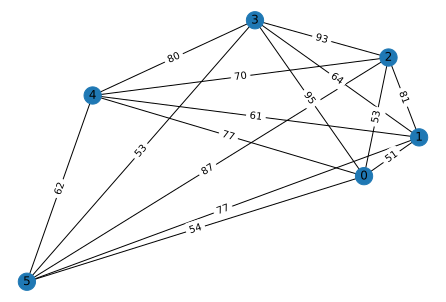

In [12]:
# Display the graph
np_example_tsp = np.array(example_tsp)
example_graph = nx.to_networkx_graph(np_example_tsp)
pos = nx.spiral_layout(example_graph, resolution=0.7)  # positions for all nodes
nx.draw(example_graph, pos, with_labels=True)
labels = nx.get_edge_attributes(example_graph,'weight')
nx.draw_networkx_edge_labels(example_graph,pos,edge_labels=labels)
plt.axis()
plt.show()

In [13]:
_ = compare(example_tsp, lp = "none", PRINT = True)

---------------------Comparison of Algorithms---------------------


,Hamiltonian Cycles,Distances,Ratio wrt Brute Force
Algorithms,,,
Brute Force,"[0, 1, 3, 5, 4, 2, 0]",353,1.000000
MST Algo,"[0, 5, 3, 2, 1, 4, 0]",419,1.186969
Christofides,"[0, 2, 5, 3, 4, 1, 0]",385,1.090652


# Comparison of Algorithms

## Execution Time

**Implementation:**
- Since brute force increases highly exponentially, it compresses the other graphs.
- We have displayed 2 other graphs for execution time without brute force.


--------------------- Time Taken vs N ---------------------


Average                        ... Standard Deviation                    
        N       brute       ilp  ...                ilp       mst  christof
0       3    0.000022  0.471032  ...           0.929756  0.000127  0.000475
1       4    0.000031  0.074448  ...           0.007475  0.000131  0.000211
2       5    0.000062  0.065678  ...           0.009813  0.000507  0.000323
3       6    0.000265  0.103877  ...           0.041033  0.000627  0.000448
4       7    0.001262  0.122729  ...           0.049384  0.000231  0.000161
5       8    0.026764  0.195055  ...           0.028881  0.000017  0.000138
6       9    0.078659  0.372005  ...           0.187337  0.000039  0.000163
7      10    0.780092  0.278973  ...           0.089953  0.000150  0.000318
8      11    8.247344  0.350626  ...           0.120069  0.000304  0.000291
9      12  101.741996  0.986121  ...           0.500464  0.000714  0.000389

[10 rows x 10 columns]

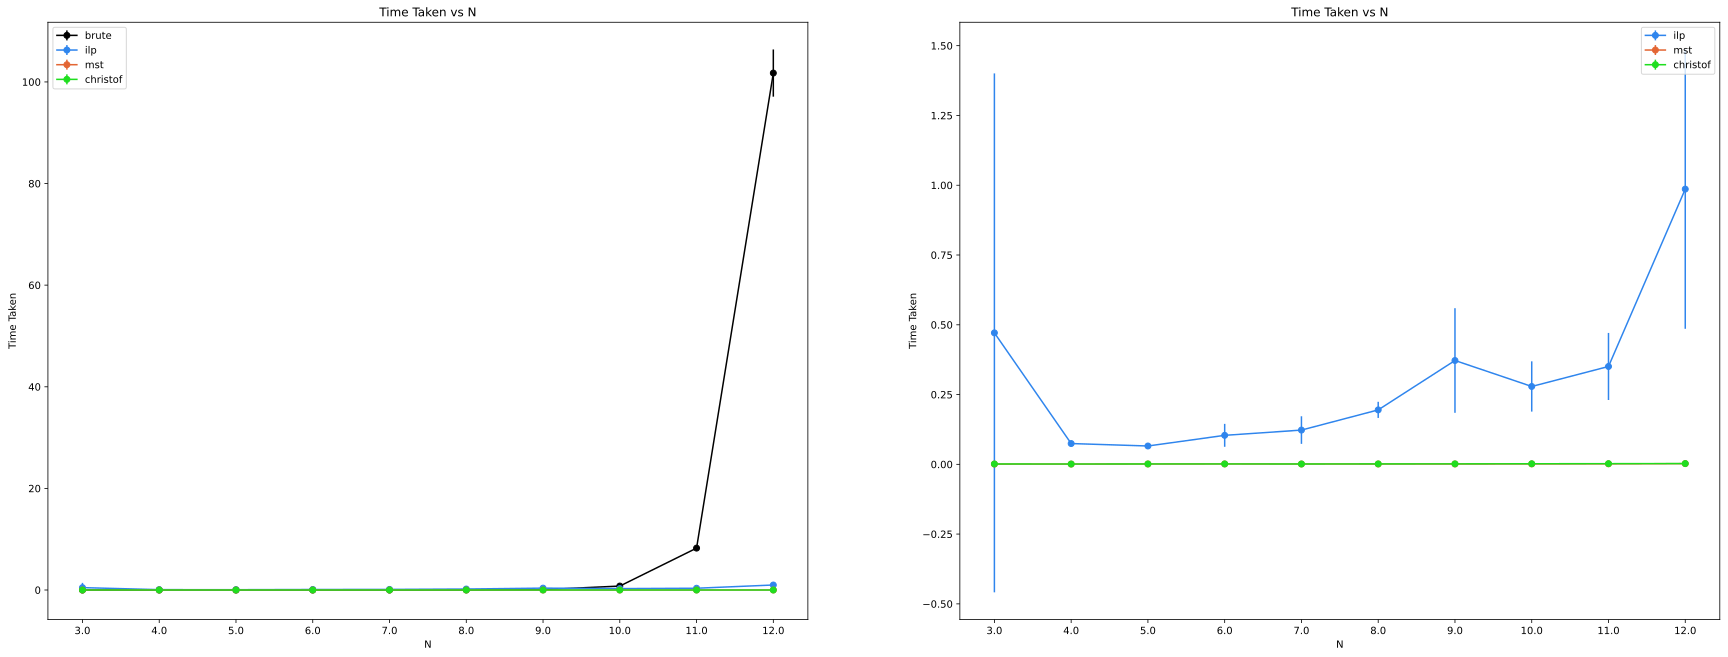

In [14]:
compare_algos(3,12,100,500,100,lp = "none",COMPARE = "time")

**Findings:**
- As expected, execution time for the brute force and ILP algorithm increases exponentially.
- Execution time for ILP algorithm grows with a smaller rate than Brute Force.
- For small n, Execution time for ILP is higher than brute force but is overtaken by brute force due to the difference in growth rate.
- The approximation algorithms are much more efficient than the exact algorithms and take somewhat similar execution time.

## Performance Ratios

Executing the respective algorithms 20 times for each n.

**Implementation:**
- Since there is a high standard deviation in both the graphs, it overlaps.
- We have displayed 3 separate graphs for costs, with and without standard deviations.


--------------------- Ratio of Costs vs N ---------------------


Average                     Standard Deviation                    
         N       mst  christof                  N       mst  christof
0        3  1.000000  1.000000                  3  0.000000  0.000000
1        4  1.040126  1.007202                  4  0.042181  0.012897
2        5  1.037848  1.017558                  5  0.034307  0.023717
3        6  1.064684  1.031792                  6  0.049344  0.029502
4        7  1.091085  1.057607                  7  0.060880  0.040445
5        8  1.093069  1.047332                  8  0.048645  0.040911
6        9  1.087316  1.057002                  9  0.046121  0.044409
7       10  1.120783  1.057381                 10  0.050609  0.029701
8       11  1.108871  1.057987                 11  0.045804  0.027859
9       12  1.142826  1.073308                 12  0.053940  0.042891
10      13  1.126735  1.079635                 13  0.054500  0.032844

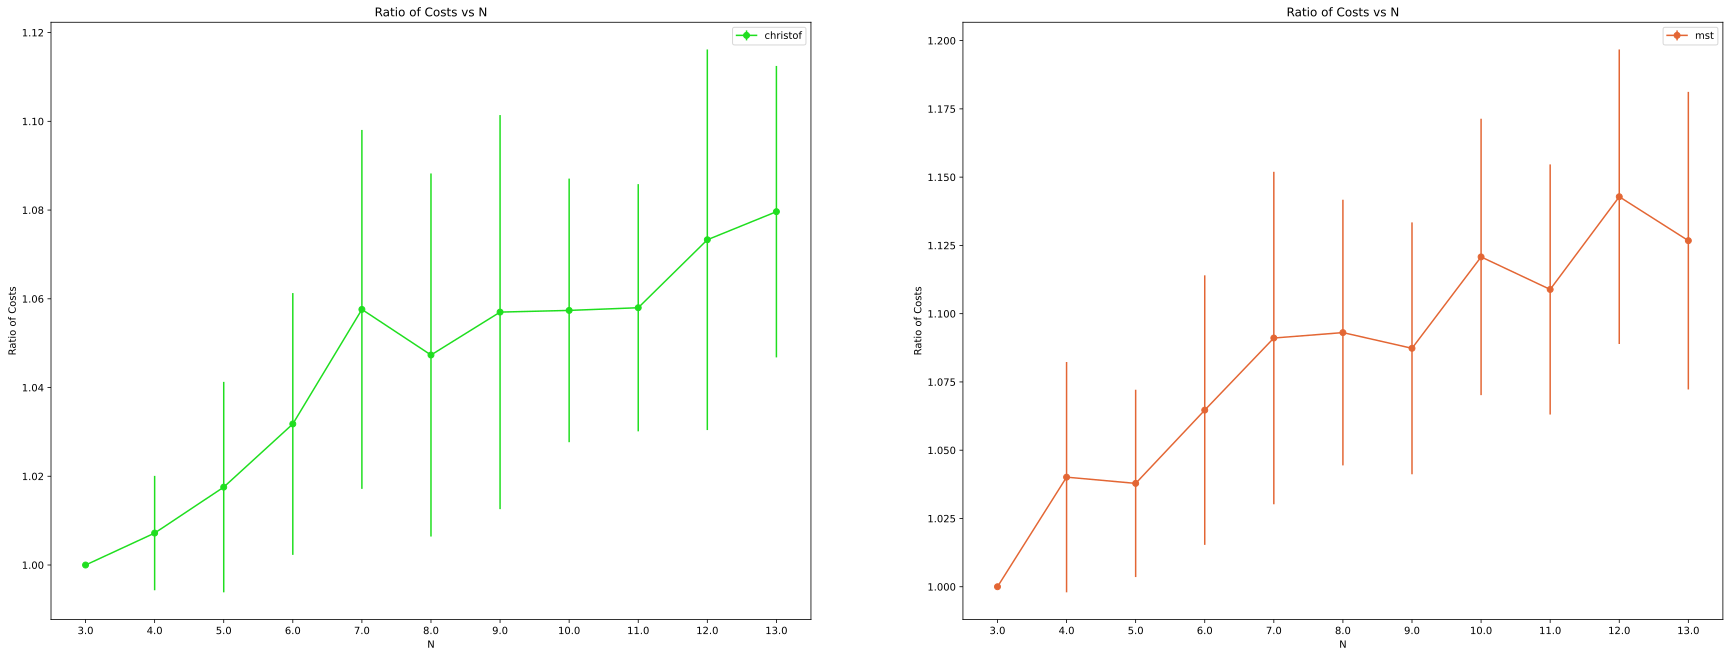

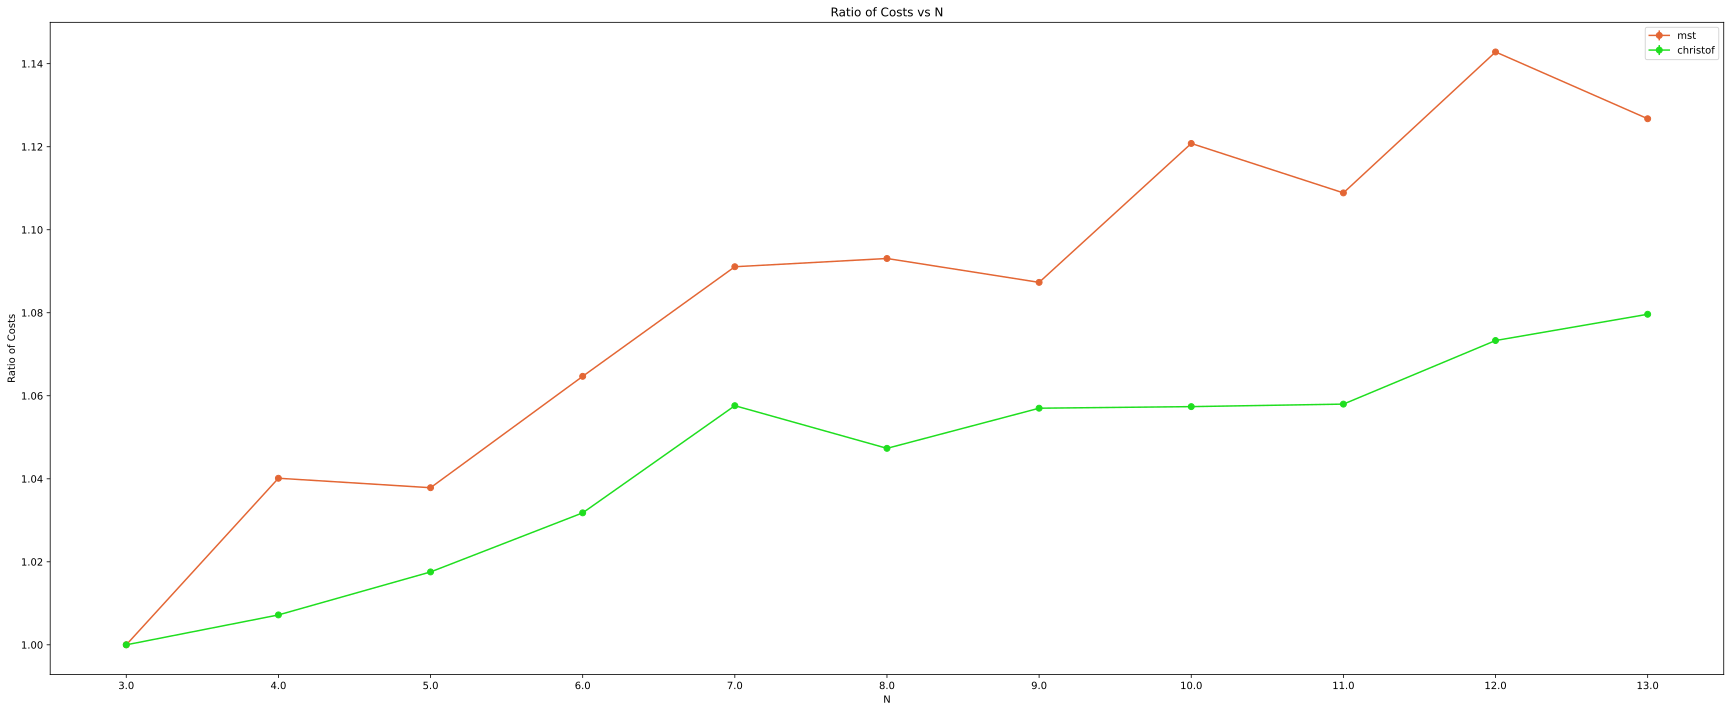

In [15]:
compare_algos(3,13,100,4100,200,lp = "ilp",COMPARE = "cost")

**Findings:**
- There is a gradual increase in the performance ratio for both MST and Christofides algorithms.
- As expected, Christofides algorithm has a better (lower) performance ratio.